In [1]:
# %matplotlib ipympl
# %matplotlib notebook
# %matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [83]:
import sys
import cv2
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import impyute as impy
import tensorflow as tf

from ai_badminton.trajectory import Trajectory
from ai_badminton.hit_detector import AdhocHitDetector, MLHitDetector
from ai_badminton.pose import Pose, read_player_poses, process_pose_file
from ai_badminton.court import Court, read_court
from ai_badminton.video_annotator import annotate_video

In [3]:
# Import shuttle trajectories and poses
root_name = 'anthony-ginting-beat-kento-momota-anthony-ginting-vs-kento-momota-fo-2019-hlzrivktbyo'

# Get poses and trajectories
trajectory = Trajectory('./data/%s_predict.csv' % root_name)

# Get video
cap = cv2.VideoCapture('./data/%s.mp4' % root_name)
if cap.isOpened() is False:
    print('Error opening video stream or file')

fps = cap.get(cv2.CAP_PROP_FPS)

In [4]:
# Some outlier detection programs
# from sklearn.ensemble import IsolationForest

# outliers_fraction = 0.05
# model =  IsolationForest(contamination=outliers_fraction)
# model.fit(trajectory.Y_pred.values.reshape(-1, 1)) 
# trajectory['anomaly_Y'] = pd.Series(model.predict(trajectory.Y_pred.values.reshape(-1, 1)))

# # visualization
# trajectory['anomaly_Y'] = pd.Series(trajectory['anomaly_Y'].values, index=trajectory.index)
# a = trajectory.loc[trajectory['anomaly_Y'] == -1] #anomaly
# _ = plt.figure(figsize=(18,6))
# _ = plt.plot(trajectory['Y_pred'], color='blue', label='Normal')
# _ = plt.plot(a['Y_pred'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
# plt.show()

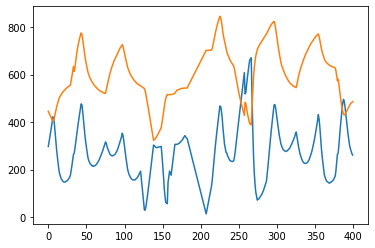

In [5]:
plt.plot(range(400), trajectory.Y[:400])
plt.plot(range(400), trajectory.X[:400])
plt.show()

In [94]:
# If pose files are not yet processed, do this:
# poses = process_pose_file('./data/%s_poses.out' % root_name, './output/%s' % root_name, court)

Read in files. Processing poses...



Separating top and bottom poses...
Done!


In [95]:
poses = read_player_poses('./output/%s' % root_name)
court = Court(
    read_court('./data/%s_court.out' % root_name)
)

Total shots hit by players: 259
Total impacts detected: 434
Distribution of shot times:
Average time between shots (s): 1.1855889145496536


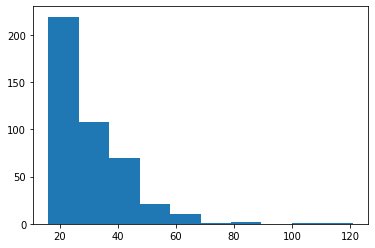

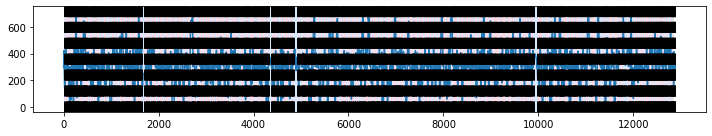

In [75]:
import ruptures as rpt

# signal
signal_x = np.array(trajectory.X)
signal_y = np.array(trajectory.Y)

# detection
detector = AdhocHitDetector(poses, trajectory)
result, is_hit = detector.detect_hits(fps)

# display
rpt.display(signal_y, result, result)
plt.show()

In [76]:
# New hit detection
os.chdir('/home/code-base/user_space/ai-badminton/notebooks')

In [77]:
detector = MLHitDetector(
    court,
    poses,
    trajectory,
    './../TrackNetv2/3_in_3_out/hitnet_conv_model_predict_player2.h5'
)

Number of layers: 18
Total params: 17331
Trainable params: 17331
Non-trainable params: 0


Total shots hit by players: 310
Total impacts detected: 354
Distribution of shot times:
Average time between shots (s): 1.1297450424929179


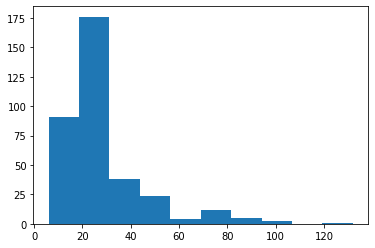

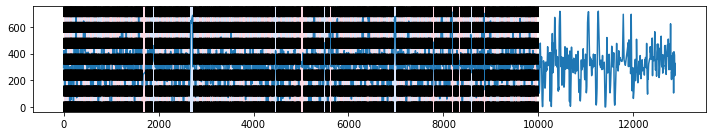

In [78]:
result, is_hit = detector.detect_hits(fps)
rpt.display(signal_y, result, result)
plt.show()

In [80]:
print(
    bottom_player.values[result[1]],
    top_player.values[result[1]],
    trajectory.X[result[1]],
    trajectory.Y[result[1]],
    sep='\n'
)

[522. 467. 525. 464. 519. 465. 514. 472. 530. 468. 511. 497. 545. 489.
 504. 526. 560. 511. 495. 553. 574. 532. 531. 548. 553. 542. 515. 586.
 553. 565. 522. 629. 579. 596.]
[581.         259.5        582.75       256.         578.75
 256.25       586.         254.5        576.         258.
 596.08333333 267.33333333 577.45454545 275.81818182 609.5
 263.33333333 569.75       278.5        604.5        259.
 577.11111111 277.44444444 598.5        290.75       586.75
 290.75       597.         324.75       577.33333333 325.
 595.25       348.75       577.5        347.75      ]
546.0
153.0


In [93]:
annotate_video(
    cap,
    court,
    poses,
    trajectory,
    result,
    is_hit
)

In [ ]:
# Find sequences of fully formed rallies
started = False
spos, lpid = 0, 0
is_rally = [0] * frame_lim
num_rallies, rally_len = 0, 0
for i, pid in enumerate(is_hit):
    if pid > 0 and not started:
        # Start the chain
        spos, lpid = i, pid
        started = True
        rally_len = 1
#         print('Started a rally!')
    elif started:
        if pid == 0:
            for j in range(spos, i+1):
                is_rally[j] = 1
            started = False
            print('Rally length:', rally_len)
            num_rallies += 1
#             print('Ended a rally!')
        elif pid == lpid:
            rally_len = 0
            spos = i
#             print('Started a new rally!')
        else:
            lpid = pid
            rally_len += 1
#     print(i, pid)

print(num_rallies)